In [2]:
# Test the integration with the Maverick UI risk model system
import sys
sys.path.append('/Users/rafet/Workspace/Spark/spark-ui/spark/ui/apps/maverick')

try:
    from config.risk_model_loader import RiskModelLoader
    
    # Create risk model loader
    loader = RiskModelLoader()
    
    print("📊 AVAILABLE RISK MODELS:")
    print("=" * 50)
    
    available_models = loader.get_available_models()
    for model in available_models:
        print(f"🔹 {model['name']}")
        print(f"   ID: {model['id']}")
        print(f"   Factors: {model['factors']}")
        print(f"   Source: {model['source']}")
        print(f"   Description: {model['description']}")
        print()
    
    # Test loading macro1 model specifically
    if 'macro1' in [m['id'] for m in available_models]:
        print("🧪 TESTING MACRO1 MODEL LOADING:")
        print("=" * 40)
        
        # Load factor returns for macro1
        macro1_returns = loader.load_model_factor_returns('macro1')
        print(f"✅ Loaded macro1 returns: {macro1_returns.shape}")
        print(f"   Factors: {list(macro1_returns.columns)}")
        print(f"   Date range: {macro1_returns.index.min()} to {macro1_returns.index.max()}")
        
        # Get model statistics
        stats = loader.get_model_statistics('macro1')
        print(f"✅ Model statistics computed")
        print(f"   Observations: {stats['observations']}")
        print(f"   Period: {stats['period_start']} to {stats['period_end']}")
        
        # Display factor statistics
        print("\n📈 FACTOR STATISTICS:")
        for factor, factor_stats in stats['factor_stats'].items():
            print(f"{factor:>12}: {factor_stats['annualized_return']:>7.1%} return, "
                  f"{factor_stats['annualized_volatility']:>7.1%} vol, "
                  f"Sharpe: {factor_stats['annualized_return']/factor_stats['annualized_volatility']:>5.2f}")
    
    else:
        print("❌ macro1 model not found in available models")
        
except Exception as e:
    print(f"❌ Error testing risk model integration: {e}")
    import traceback
    traceback.print_exc()

📊 AVAILABLE RISK MODELS:
🔹 macro1
   ID: macro1
   Factors: ['Market', 'Bonds', 'Dollar', 'Commodity', 'Credit']
   Source: definition
   Description: Pre-defined macro1 model

🔹 macro2
   ID: macro2
   Factors: ['Market', 'Curve', 'Dollar', 'Commodity', 'Credit', 'AI']
   Source: definition
   Description: Pre-defined macro2 model

🧪 TESTING MACRO1 MODEL LOADING:
Could not load real factor returns for macro1: name 'bloomberg' is not defined
✅ Loaded macro1 returns: (1305, 5)
   Factors: ['Market', 'Bonds', 'Dollar', 'Commodity', 'Credit']
   Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
✅ Model statistics computed
   Observations: 1305
   Period: 2020-01-01 to 2024-12-31

📈 FACTOR STATISTICS:
      Market:   37.5% return,   19.4% vol, Sharpe:  1.93
       Bonds:    3.7% return,   13.8% vol, Sharpe:  0.27
      Dollar:  -17.4% return,   24.8% vol, Sharpe: -0.70
   Commodity:   17.5% return,   24.7% vol, Sharpe:  0.71
      Credit:    2.5% return,   13.5% vol, Sharpe:  0.18


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Generate mock factor returns that mimic the macro1 predefined model
def generate_macro1_factor_returns(start_date='2023-01-02', end_date='2023-12-19', seed=42):
    """
    Generate realistic mock factor returns for the macro1 model.
    
    Macro1 factors: ['Market', 'Bonds', 'Dollar', 'Commodity', 'Credit']
    """
    np.random.seed(seed)
    
    # Create date range matching existing portfolio data
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')  # Business days
    
    # Factor definitions with realistic characteristics
    factor_specs = {
        'Market': {
            'daily_mean': 0.0008,      # ~20% annualized
            'daily_vol': 0.015,        # ~24% annualized vol
            'persistence': 0.05,       # Low persistence for mean reversion
            'description': 'Broad equity market factor'
        },
        'Bonds': {
            'daily_mean': 0.0003,      # ~8% annualized
            'daily_vol': 0.008,        # ~13% annualized vol
            'persistence': 0.15,       # Higher persistence for bonds
            'description': 'Government bond factor'
        },
        'Dollar': {
            'daily_mean': 0.0001,      # ~2% annualized (mean-reverting)
            'daily_vol': 0.012,        # ~19% annualized vol
            'persistence': 0.08,       # Moderate persistence
            'description': 'US Dollar strength factor'
        },
        'Commodity': {
            'daily_mean': 0.0002,      # ~5% annualized
            'daily_vol': 0.020,        # ~32% annualized vol (high volatility)
            'persistence': 0.12,       # Moderate persistence
            'description': 'Commodity price factor'
        },
        'Credit': {
            'daily_mean': 0.0004,      # ~10% annualized
            'daily_vol': 0.010,        # ~16% annualized vol
            'persistence': 0.20,       # Higher persistence for credit spreads
            'description': 'Credit spread factor'
        }
    }
    
    # Generate correlated factor returns with realistic cross-correlations
    n_periods = len(date_range)
    n_factors = len(factor_specs)
    
    # Define correlation structure (realistic macro factor correlations)
    correlation_matrix = np.array([
        # Market, Bonds, Dollar, Commodity, Credit
        [1.00,  -0.30,  0.10,   0.40,      0.60],   # Market
        [-0.30,  1.00, -0.20,  -0.15,     -0.40],   # Bonds (negative correlation with risk assets)
        [0.10,  -0.20,  1.00,  -0.25,      0.15],   # Dollar (flight to quality)
        [0.40,  -0.15, -0.25,   1.00,      0.30],   # Commodity (risk-on asset)
        [0.60,  -0.40,  0.15,   0.30,      1.00]    # Credit (risk asset)
    ])
    
    # Generate uncorrelated random shocks
    random_shocks = np.random.multivariate_normal(
        mean=np.zeros(n_factors),
        cov=correlation_matrix,
        size=n_periods
    )
    
    # Generate factor returns with persistence and realistic characteristics
    factor_returns = {}
    factor_names = list(factor_specs.keys())
    
    for i, factor_name in enumerate(factor_names):
        spec = factor_specs[factor_name]
        returns = np.zeros(n_periods)
        
        # Initialize with random shock
        returns[0] = spec['daily_mean'] + spec['daily_vol'] * random_shocks[0, i]
        
        # Generate rest of series with persistence
        for t in range(1, n_periods):
            # AR(1) process with correlation structure
            returns[t] = (
                spec['daily_mean'] * (1 - spec['persistence']) +  # Mean reversion
                spec['persistence'] * returns[t-1] +              # Persistence
                spec['daily_vol'] * random_shocks[t, i]          # Correlated shock
            )
        
        factor_returns[factor_name] = returns
    
    # Create DataFrame
    macro1_returns = pd.DataFrame(factor_returns, index=date_range)
    
    # Add some realistic regime changes (market stress periods)
    # Simulate a few stressed periods
    stress_periods = [
        (pd.Timestamp('2023-03-10'), pd.Timestamp('2023-03-20')),  # Banking stress
        (pd.Timestamp('2023-10-05'), pd.Timestamp('2023-10-15')),  # Geopolitical stress
    ]
    
    for start_stress, end_stress in stress_periods:
        mask = (macro1_returns.index >= start_stress) & (macro1_returns.index <= end_stress)
        if mask.any():
            # During stress: Market down, Bonds up, Dollar up, Commodities down, Credit spreads widen
            macro1_returns.loc[mask, 'Market'] *= 1.5      # Higher volatility
            macro1_returns.loc[mask, 'Market'] -= 0.003    # Negative bias
            
            macro1_returns.loc[mask, 'Bonds'] *= 0.7       # Lower volatility (flight to quality)
            macro1_returns.loc[mask, 'Bonds'] += 0.002     # Positive bias
            
            macro1_returns.loc[mask, 'Dollar'] += 0.001    # Safe haven demand
            
            macro1_returns.loc[mask, 'Commodity'] *= 1.3   # Higher volatility
            macro1_returns.loc[mask, 'Commodity'] -= 0.002 # Negative bias
            
            macro1_returns.loc[mask, 'Credit'] *= 1.4      # Higher volatility (widening spreads)
            macro1_returns.loc[mask, 'Credit'] -= 0.001    # Negative bias
    
    return macro1_returns

# Generate the macro1 factor returns
macro1_factor_returns = generate_macro1_factor_returns()

print("Macro1 Factor Returns Generated:")
print(f"Shape: {macro1_factor_returns.shape}")
print(f"Date range: {macro1_factor_returns.index.min()} to {macro1_factor_returns.index.max()}")
print(f"Factors: {list(macro1_factor_returns.columns)}")

# Display basic statistics
print("\nAnnualized Statistics:")
for factor in macro1_factor_returns.columns:
    annual_return = macro1_factor_returns[factor].mean() * 252
    annual_vol = macro1_factor_returns[factor].std() * np.sqrt(252)
    print(f"{factor:>10}: Return={annual_return:>7.1%}, Vol={annual_vol:>7.1%}")

# Show correlation matrix
print("\nFactor Correlations:")
print(macro1_factor_returns.corr().round(2))

# Display first few rows
print("\nFirst 10 rows:")
macro1_factor_returns.head(10)

Macro1 Factor Returns Generated:
Shape: (252, 5)
Date range: 2023-01-02 00:00:00 to 2023-12-19 00:00:00
Factors: ['Market', 'Bonds', 'Dollar', 'Commodity', 'Credit']

Annualized Statistics:
    Market: Return=  35.7%, Vol=  23.9%
     Bonds: Return=   7.1%, Vol=  11.7%
    Dollar: Return=  -1.1%, Vol=  19.2%
 Commodity: Return= -47.9%, Vol=  33.2%
    Credit: Return=  -1.5%, Vol=  16.4%

Factor Correlations:
           Market  Bonds  Dollar  Commodity  Credit
Market       1.00  -0.25    0.03       0.43    0.56
Bonds       -0.25   1.00   -0.20      -0.08   -0.28
Dollar       0.03  -0.20    1.00      -0.31    0.14
Commodity    0.43  -0.08   -0.31       1.00    0.28
Credit       0.56  -0.28    0.14       0.28    1.00

First 10 rows:


,Market,Bonds,Dollar,Commodity,Credit
2023-01-02,-0.007756,-0.000767,-0.008613,-0.021876,0.001358
2023-01-03,0.003978,-0.001723,-0.017080,0.023926,-0.003647
2023-01-04,-0.009295,-0.003849,0.013844,0.026262,0.004146
2023-01-05,-0.006038,-0.006575,0.016997,0.009667,0.008943
2023-01-06,-0.024219,0.005809,0.007614,-0.002164,-0.012573
2023-01-09,-0.007885,-0.003311,0.014146,-0.009083,-0.003503
2023-01-10,0.013579,0.000834,-0.012194,0.038152,-0.003684
2023-01-11,0.025700,0.005446,0.011983,0.033675,0.007353
2023-01-12,-0.016394,0.006987,0.000547,0.004918,0.000584
2023-01-13,-0.007703,-0.007968,0.002480,0.004301,0.013516


✅ Saved macro1 factor returns to: config/data/factor_returns_macro1.parquet
✅ Verification successful: (252, 5)
   Columns: ['Market', 'Bonds', 'Dollar', 'Commodity', 'Credit']
   Date range: 2023-01-02 00:00:00 to 2023-12-19 00:00:00


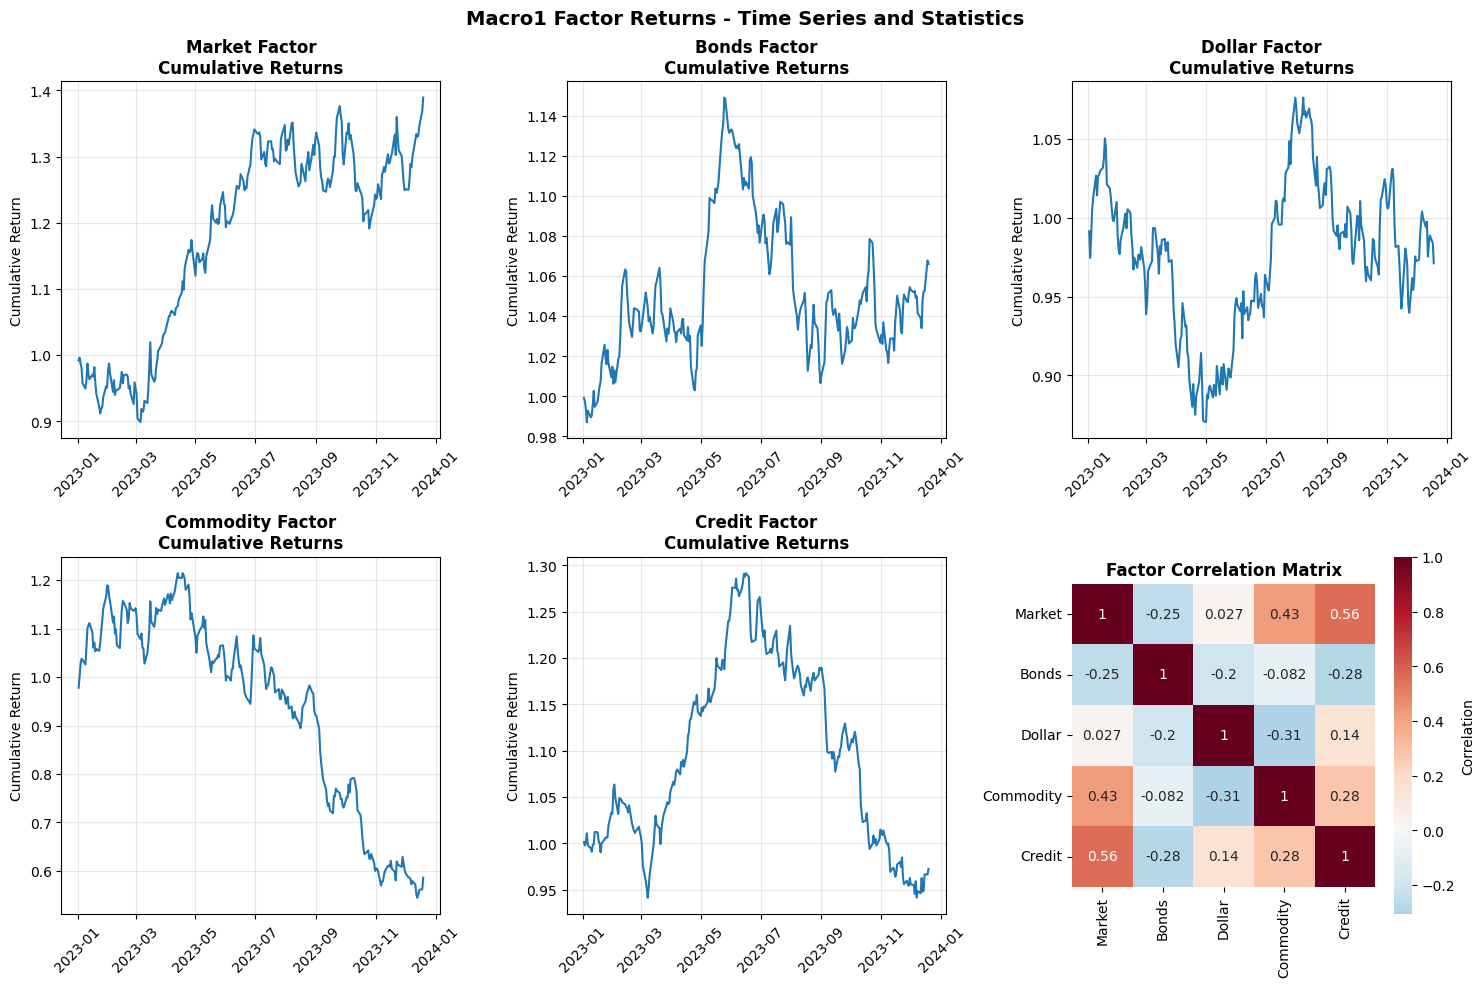


MACRO1 FACTOR RETURNS SUMMARY
   Factor Ann. Return Ann. Volatility Sharpe Ratio Min Daily Max Daily
   Market       35.7%           23.9%         1.49    -0.047     0.044
    Bonds        7.1%           11.7%         0.60    -0.017     0.019
   Dollar       -1.1%           19.2%        -0.06    -0.028     0.032
Commodity      -47.9%           33.2%        -1.44    -0.055     0.068
   Credit       -1.5%           16.4%        -0.09    -0.034     0.025


In [4]:
# Save the macro1 factor returns to the data directory
output_path = "config/data/factor_returns_macro1.parquet"
macro1_factor_returns.to_parquet(output_path)
print(f"✅ Saved macro1 factor returns to: {output_path}")

# Verify the file was created and can be read back
try:
    loaded_data = pd.read_parquet(output_path)
    print(f"✅ Verification successful: {loaded_data.shape}")
    print(f"   Columns: {list(loaded_data.columns)}")
    print(f"   Date range: {loaded_data.index.min()} to {loaded_data.index.max()}")
except Exception as e:
    print(f"❌ Error verifying saved file: {e}")

# Also create a visualization to show the factor behavior
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Macro1 Factor Returns - Time Series and Statistics', fontsize=14, fontweight='bold')

# Plot time series for each factor
for i, factor in enumerate(macro1_factor_returns.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Cumulative returns
    cumulative = (1 + macro1_factor_returns[factor]).cumprod()
    ax.plot(cumulative.index, cumulative.values, linewidth=1.5, label=factor)
    ax.set_title(f'{factor} Factor\nCumulative Returns', fontweight='bold')
    ax.set_ylabel('Cumulative Return')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Remove empty subplot
axes[1, 2].remove()

# Add correlation heatmap in the last subplot position
ax_corr = fig.add_subplot(2, 3, 6)
correlation_matrix = macro1_factor_returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=ax_corr, cbar_kws={'label': 'Correlation'})
ax_corr.set_title('Factor Correlation Matrix', fontweight='bold')

plt.tight_layout()
plt.show()

# Display summary table
print("\n" + "="*60)
print("MACRO1 FACTOR RETURNS SUMMARY")
print("="*60)

summary_stats = pd.DataFrame({
    'Factor': macro1_factor_returns.columns,
    'Ann. Return': [f"{macro1_factor_returns[col].mean() * 252:.1%}" for col in macro1_factor_returns.columns],
    'Ann. Volatility': [f"{macro1_factor_returns[col].std() * np.sqrt(252):.1%}" for col in macro1_factor_returns.columns],
    'Sharpe Ratio': [f"{(macro1_factor_returns[col].mean() * 252) / (macro1_factor_returns[col].std() * np.sqrt(252)):.2f}" for col in macro1_factor_returns.columns],
    'Min Daily': [f"{macro1_factor_returns[col].min():.3f}" for col in macro1_factor_returns.columns],
    'Max Daily': [f"{macro1_factor_returns[col].max():.3f}" for col in macro1_factor_returns.columns]
})

print(summary_stats.to_string(index=False))
print("="*60)

In [19]:
macro1_factor_returns.index.name = 'date'
tall = macro1_factor_returns.melt(var_name='factor_name', value_name="value_column", ignore_index=False).reset_index()
tall["riskmodel_code"] = "macro1"
tall.to_parquet("config/data/factor_returns.parquet", index=False)
pd.read_parquet("config/data/factor_returns.parquet")   



,date,factor_name,value_column,riskmodel_code
0,2023-01-02,Market,-0.007756,macro1
1,2023-01-03,Market,0.003978,macro1
2,2023-01-04,Market,-0.009295,macro1
3,2023-01-05,Market,-0.006038,macro1
4,2023-01-06,Market,-0.024219,macro1
...,...,...,...,...
1255,2023-12-13,Credit,-0.015192,macro1
1256,2023-12-14,Credit,0.000756,macro1
1257,2023-12-15,Credit,0.018849,macro1
1258,2023-12-18,Credit,-0.000155,macro1
